# Kaggle 데이터 분석 프로젝트
## 3조 Kacher

---

## **데이터 살펴보기**

#### 데이터 불러오기

In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [562]:
df_train = pd.read_csv('sales_train.csv')
df_items = pd.read_csv('items.csv',encoding='cp949')
df_shops = pd.read_csv('shops.csv')
df_item_categories = pd.read_csv('item_categories.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

#### 데이터 살펴보기

In [563]:
print(df_train.shape, df_items.shape, df_shops.shape, df_item_categories.shape, df_test.shape, sep='\n-----------\n')

(2935849, 6)
-----------
(22170, 3)
-----------
(60, 2)
-----------
(84, 2)
-----------
(214200, 3)


In [564]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [565]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [566]:
df_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [567]:
df_item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [568]:
df_item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


러시아어로는 데이터를 이해하는 것에 어려움이 있어 item_category_name을 한글로 번역하여 item_category_kor.csv로 저장하였다.

In [569]:
from googletrans import Translator

trans = Translator()
def translate(column):
    en_list=[]
    for word in column:
        en = trans.translate(word, dest='ko')
        en_list.append(en.text)
    return en_list

In [570]:
df_item_categories['item_category_name'] = translate(df_item_categories.item_category_name)

In [571]:
df_item_categories.to_csv('item_categories_kor.csv')
df_item_categories = pd.read_csv('item_categories_kor.csv')

In [572]:
df_item_categories.head()

,Unnamed: 0,item_category_name,item_category_id
0,0,PC - 헤드셋 / 헤드폰,0
1,1,액세서리 - PS2.,1
2,2,액세서리 - PS3.,2
3,3,액세서리 - PS4.,3
4,4,액세서리 - PSP.,4


In [573]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


---

## **데이터 전처리**

### 이상치 제거

##### ㆍ중복체크

In [449]:
# train 데이터 중복체크
df_train.duplicated().sum()

6

In [450]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

In [451]:
print(df_item_categories.duplicated().sum())
print(df_items.duplicated().sum())
print(df_shops.duplicated().sum())
print(df_test.duplicated().sum())

0
0
0
0


df_train 데이터를 제외한 데이터 셋에선 중복값이 발견되지 않았음

##### ㆍ결측치 확인


In [452]:
print(df_train.isnull().sum())
print(df_item_categories.isnull().sum())
print(df_items.isnull().sum())
print(df_shops.isnull().sum())
print(df_test.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
Unnamed: 0            0
item_category_name    0
item_category_id      0
dtype: int64
item_name           0
item_id             0
item_category_id    0
dtype: int64
shop_name    0
shop_id      0
dtype: int64
ID         0
shop_id    0
item_id    0
dtype: int64


<AxesSubplot:title={'center':'shops'}>

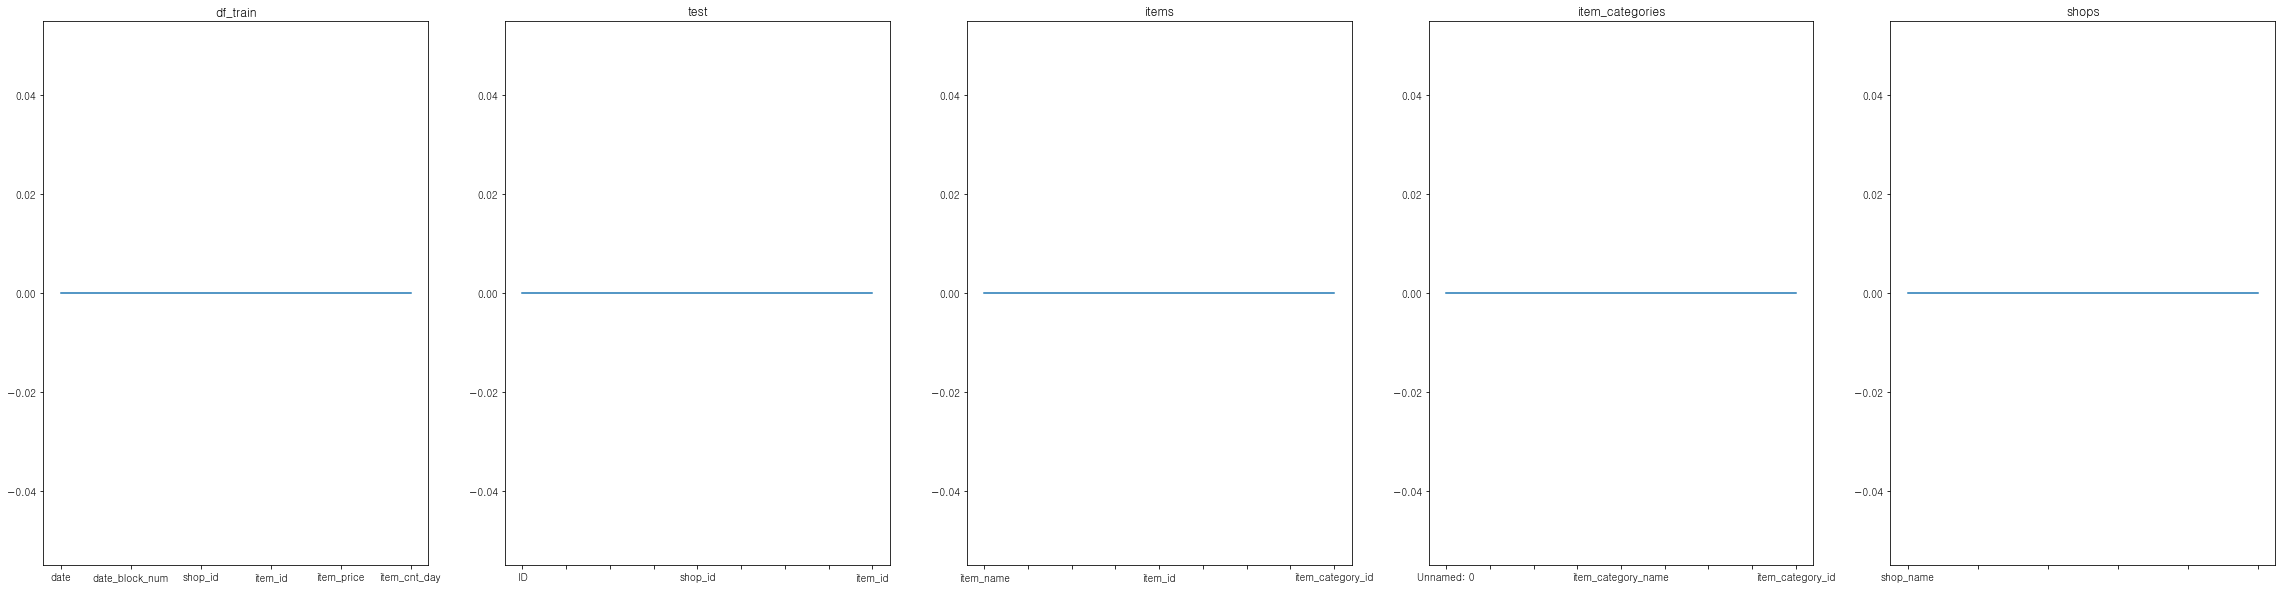

In [453]:
figure, ((ax1,ax2,ax3,ax4,ax5)) = plt.subplots(nrows=1, ncols=5)
figure.set_size_inches(40,10)

df_train.isnull().sum().plot(title='df_train', ax=ax1)
df_test.isnull().sum().plot(title='test',ax=ax2)
df_items.isnull().sum().plot(title='items',ax=ax3)
df_item_categories.isnull().sum().plot(title='item_categories',ax=ax4)
df_shops.isnull().sum().plot(title='shops',ax=ax5)

그래프로 확인했을 때도 결측값이 발견되지 않는다.

##### ㆍ특이값 제거


train data set에서 기준 데이터 범위에 많이 벗어나거나 미달하는 특이값이 발견되었다. 때문에 train data set에서 이를 처리해준다.

<AxesSubplot:xlabel='item_price'>

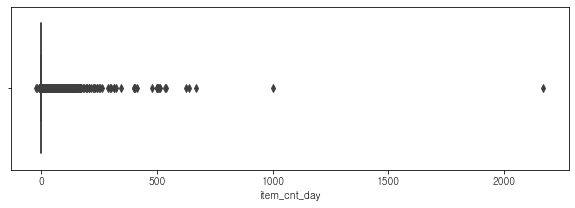

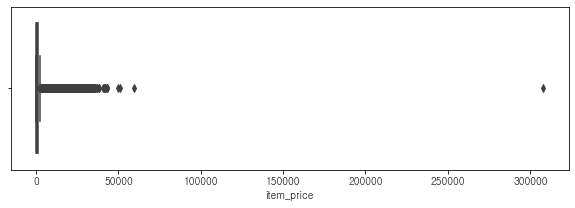

In [454]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train)

In [455]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [456]:
df_train = df_train[df_train.item_cnt_day < 1000]
df_train = df_train.query('item_price < 50000 & item_price > 0')

- 'item_cnt_day' 값이 2000 이상인 값은 이상치로 판단함.
- 'item_cnt_day' 컬럼에서 0 미만인 값은 '환불'이라고 생각하여 이상치로 판단하지 않음.
- 'item_price' 값은 0 미만인 값, 50000 초과하는 값을 이상치로 설정함.

<AxesSubplot:xlabel='item_price'>

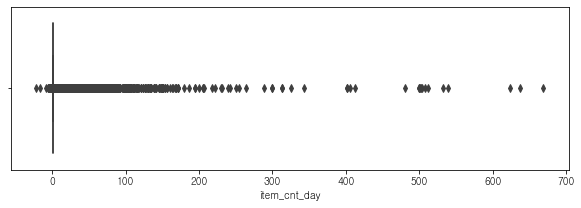

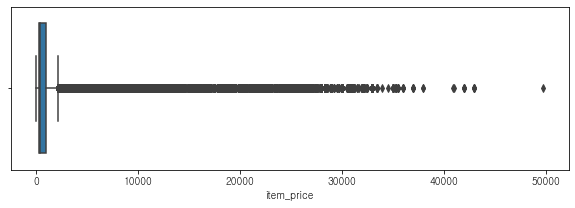

In [457]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train)

##### ㆍData leakage 처리

Data leakage가 존재하여 test set에 존재하는 shop_id , item_id 만 사용하기로 한다.

In [458]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [417]:
# test set에 있는 shop, item만 사용
test_shop_ids = df_test['shop_id'].unique()
test_item_ids = df_test['item_id'].unique()

In [418]:
print(test_shop_ids, test_item_ids)

[ 5  4  6  3  2  7 10 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53
 52 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45] [ 5037  5320  5233 ... 15757 19648   969]


In [419]:
# test set의 shop_id와 일치하는 데이터만 사용
lk_train = df_train[df_train['shop_id'].isin(test_shop_ids)]
# test set의 item_id와 일치하는 데이터만 사용
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [420]:
print('Data leaking 전의 Data set size: ', df_train.shape[0])
print('Data leaking 후의 Data set size: ', lk_train.shape[0])

Data leaking 전의 Data set size:  2935837
Data leaking 후의 Data set size:  1224431


In [433]:
df_train = lk_train

### 데이터 그룹화

월별(date_block_num), 가게별(shop_id), 물품별(item_id)을 기준으로 판매량(item_cnt_day)을 더한 데이터 프레임 group1을 생성한다.

In [574]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [575]:
group1 = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group1.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [576]:
group1.columns = ['item_cnt_month']
group1 = group1.reset_index()

In [577]:
group1.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [578]:
group1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1609124 non-null  int64  
 1   shop_id         1609124 non-null  int64  
 2   item_id         1609124 non-null  int64  
 3   item_cnt_month  1609124 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 49.1 MB


월별(date_block_num), 가게별(shop_id), 물품별(item_id)을 기준으로 물품 가격(item_price)의 평균을 구하는 데이터 프레임 group2을 생성한다.

In [579]:
group2 = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price': ['mean']})
group2.head()

item_price
                                     mean
date_block_num shop_id item_id           
0              0       32           221.0
                       33           347.0
                       35           247.0
                       43           221.0
                       51           128.5

In [580]:
group2.columns = ['item_price']
group2 = group2.reset_index()

In [581]:
group2.head()

,date_block_num,shop_id,item_id,item_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [582]:
group2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1609124 non-null  int64  
 1   shop_id         1609124 non-null  int64  
 2   item_id         1609124 non-null  int64  
 3   item_price      1609124 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 49.1 MB


생성해 준 [group1, gropu2]를 'date_block_num','shop_id','item_id' 기준으로 merge한다.

In [583]:
matrix = pd.merge(group1, group2 ,how='left', on=['date_block_num','shop_id','item_id']).reset_index()

In [584]:
matrix

,index,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,0,32,6.0,221.0
1,1,0,0,33,3.0,347.0
2,2,0,0,35,1.0,247.0
3,3,0,0,43,1.0,221.0
4,4,0,0,51,2.0,128.5
...,...,...,...,...,...,...
1609119,1609119,33,59,22087,6.0,119.0
1609120,1609120,33,59,22088,2.0,119.0
1609121,1609121,33,59,22091,1.0,179.0
1609122,1609122,33,59,22100,1.0,629.0


In [585]:
matrix.drop(['index'],axis=1,inplace=True)

In [586]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [587]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1609124 non-null  int64  
 1   shop_id         1609124 non-null  int64  
 2   item_id         1609124 non-null  int64  
 3   item_cnt_month  1609124 non-null  float64
 4   item_price      1609124 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 61.4 MB


In [318]:
# matrix 데이터 null값 확인
matrix.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
item_price        0
dtype: int64

### 필요한 column 추가

#### 1. 도시 분류 추가, 매장 형태별 분류 추가

df_shop data set의 데이터를 [수도, 비수도, 기타]로 원핫 인코딩을 사용하여 병합한다.

In [589]:
shp_city = ['야쿠츠크', '야쿠츠크', '아디게야', '발라시하', '볼츠스키',
           '볼로그다', '보로네슈', '보로네슈','보로네슈', '브로네슈',
           '쥬코브스키', '쥬코브스키', '온라인', '카잔', '카잔',
           '칼루가', '콜롬나', '크라스노야르스크', '크라스노야르스크', '쿠르스크',
           '모스크바', '모스크바', '모스크바', '모스크바', '모스크바',
           '모스크바', '모스크바', '모스크바', '모스크바', '모스크바',
           '모스크바', '모스크바', '모스크바', '미티시치', '니즈니노브고로드',
           '니즈니노브고로드', '노보시비르스크','노보시비르스크', '옴스크', '로스토프온돈',
           '로스토프온돈', '로스토프온돈', '상트페테르부르크', '상트페테르부르크', '사마라',
           '사마라', '세르기예프 포사트', '수르구트', '톰스크', '투먼',
           '투먼', '투먼', '우파', '우파', '힘키',
           '모스크바','모스크바', '아쿠츠크', '아쿠츠크', '야로슬라블']

for i in range(len(shp_city)):
    if shp_city[i] == '모스크바':
        pass
    elif shp_city[i] == '온라인':
        pass
    else:
        shp_city[i] = '비수도'
shp_city

['비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '온라인',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '모스크바',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '비수도',
 '모스크바',
 '모스크바',
 '비수도',
 '비수도',
 '비수도']

In [590]:
df_shops = pd.concat([df_shops, pd.get_dummies(shp_city)], axis=1)
df_shops.columns = ['shop_name', 'shop_id', 'capital', 'non_capital', 'city_etc']

In [591]:
df_shops.head()

,shop_name,shop_id,capital,non_capital,city_etc
0,"!Якутск Орджоникидзе, 56 фран",0,0,1,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0,1,0
2,"Адыгея ТЦ ""Мега""",2,0,1,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,0,1,0
4,"Волжский ТЦ ""Волга Молл""",4,0,1,0


df_shops data set에 매장별 타입(shp_type)을 추가한다. 

In [592]:
# 쇼핑몰, 컴퓨터 용품점, 기타, 온라인몰
shp_type = ['기타', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '기타', '쇼핑몰', '쇼핑몰', '기타',
           '기타', '기타', '온라인몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '기타', '쇼핑몰', '쇼핑몰', '컴퓨터용품점', '컴퓨터용품점',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '컴퓨터용품점', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰']

In [593]:
df_shops = pd.concat([df_shops, pd.get_dummies(shp_type)], axis=1)
df_shops = df_shops[['shop_name', 'shop_id', 'capital', 'non_capital', 'city_etc', '쇼핑몰', '온라인몰', '컴퓨터용품점', '기타']]
df_shops.columns = ['shop_name', 'shop_id', 'capital', 'non_capital', 'city_etc', 'shopping_mall', 'online_mall', 'computer_mall', 'type_etc']

In [594]:
df_shops.head()

,shop_name,shop_id,capital,non_capital,city_etc,shopping_mall,online_mall,computer_mall,type_etc
0,"!Якутск Орджоникидзе, 56 фран",0,0,1,0,0,0,0,1
1,"!Якутск ТЦ ""Центральный"" фран",1,0,1,0,1,0,0,0
2,"Адыгея ТЦ ""Мега""",2,0,1,0,1,0,0,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,0,1,0,1,0,0,0
4,"Волжский ТЦ ""Волга Молл""",4,0,1,0,1,0,0,0


#### 2. 물품 카테고리 추가

In [595]:
df_item_categories.head()

,Unnamed: 0,item_category_name,item_category_id
0,0,PC - 헤드셋 / 헤드폰,0
1,1,액세서리 - PS2.,1
2,2,액세서리 - PS3.,2
3,3,액세서리 - PS4.,3
4,4,액세서리 - PSP.,4


In [596]:
cat1, cat2 = [], []
for item in df_item_categories.item_category_name:
    
    _ = item.split('-')
    cat1.append(_[0].strip())
    try: 
        cat2.append(_[1].strip())
    except:
        cat2.append(np.nan)

In [598]:
le = LabelEncoder()
df_item_categories['type_code'] = le.fit_transform(cat1)
df_item_categories['subtype_code'] = le.fit_transform(cat2)

In [599]:
df_item_categories.head()

,Unnamed: 0,item_category_name,item_category_id,type_code,subtype_code
0,0,PC - 헤드셋 / 헤드폰,0,0,61
1,1,액세서리 - PS2.,1,11,6
2,2,액세서리 - PS3.,2,11,7
3,3,액세서리 - PS4.,3,11,8
4,4,액세서리 - PSP.,4,11,10


물품 type과 subtype을 라벨 인코딩하여 item_categories data set에 추가시켰다.

In [600]:
df_item_categories.drop(columns='item_category_name', inplace=True)

필요없는 데이터인 'item_category_name' 컬럼을 삭제했다.

In [601]:
df_item_categories.head()

,Unnamed: 0,item_category_id,type_code,subtype_code
0,0,0,0,61
1,1,1,11,6
2,2,2,11,7
3,3,3,11,8
4,4,4,11,10


In [602]:
# type code 원소 확인
df_item_categories.type_code.unique()

array([ 0, 11, 19,  6,  4,  3,  2, 10,  5,  1, 15, 14, 21,  9, 16, 12,  8,
       20,  7, 18, 17, 13], dtype=int64)

## **Feature engineering**

### 1. Matrix에 Test data 병합

예측값을 생성하기 위해서는 학습값의 컬럼과 동일한 컬럼을 테스트데이터 셋에서도 있어야 하기 때문에 df_test를 matrix에 합해 feature를 동시에 생성 후 분리시킨다.
테스트 데이터는 학습 데이터 이후의 달이기 때문에 date_block_num을 34로 생성한다.

In [603]:
matrix_test = df_test.copy()
matrix_test['date_block_num'] = 34

In [604]:
matrix_test.tail()

,ID,shop_id,item_id,date_block_num
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34
214199,214199,45,969,34


item_category_id 컬럼을 추가하기 위해 df_item_categories와 df_item을 merge하여 사용한다. ID 컬럼은 sub_id로 분리한다.

In [605]:
temp_items = pd.merge(df_item_categories, df_items, on = 'item_category_id')[['item_category_id', 'item_id']]
matrix_test = pd.merge(matrix_test, temp_items, on='item_id', how='left')
sub_id = matrix_test["ID"]
matrix_test.drop(columns='ID', inplace=True)
matrix_test.tail()

,shop_id,item_id,date_block_num,item_category_id
214195,45,18454,34,55
214196,45,16188,34,64
214197,45,15757,34,55
214198,45,19648,34,40
214199,45,969,34,37


item_price의 정보는 다음과 같은 방법을 사용해 입력한다.
1. 전체 기간 중 아이템, 매장별 평균가로 입력한다. 이 때 102796개의 nan이 발생한다.

In [606]:
# # 1. price : 전체 기간 중 아이템, 샵별 평균을 구해 적용. 102796개의 nan 발생.
price_candidate_1 = matrix.groupby(['item_id', 'shop_id']).mean().reset_index()
price_candidate_1 = price_candidate_1[['item_id', 'shop_id', 'item_price']]
price_candidate_1

matrix_test = pd.merge(matrix_test, price_candidate_1, on=['item_id','shop_id'], how='left')
matrix_test
matrix_test.isna().sum()

shop_id                  0
item_id                  0
date_block_num           0
item_category_id         0
item_price          102796
dtype: int64

2. nan이 발생한 아이템에 대해서는 매장별로 아이템이 속한 카테고리의 평균가로 nan을 입력한다. 이 때 24964개의 nan이 발생한다.

In [607]:
# # 2. shop_id별로 item_id의 상위 레벨에 해당하는 item_category_id로 nan 값을 대치. 24964개의 nan 발생
temp = pd.merge(df_items, df_item_categories, on='item_category_id', how='left')
temp = temp[['item_id', 'item_category_id']]
temp = pd.merge(matrix, temp, on='item_id', how='left')

price_candidate_2 = temp.groupby(['item_category_id', 'shop_id']).mean().reset_index()
price_candidate_2 = price_candidate_2[['item_category_id', 'shop_id', 'item_price']]

In [608]:
# 결측값 업데이트
def update_price_2(x):
    if pd.isna(x['item_price']):
        search_res = price_candidate_2.loc[(price_candidate_2['item_category_id'] == x['item_category_id']) & 
                                (price_candidate_2['shop_id'] == x['shop_id'])].values
        if len(search_res) > 0: return search_res[0][2]
    return x['item_price']

matrix_test['item_price'] = matrix_test.apply(update_price_2, axis=1)
matrix_test.isna().sum()

shop_id                 0
item_id                 0
date_block_num          0
item_category_id        0
item_price          24137
dtype: int64

3. 매장별 아이템 카테고리의 평균가에서도 nan이 발생한 항목에 대해서는 전 매장에서의 아이템 카테고리의 평균가로 입력한다. 이 때 84 개의 nan이 발생한다.

In [524]:
# 3. 모든 매장에 통틀어 item_category_id의 평균가로 nan값을 대치.

price_candidate_3 = temp.groupby(['item_category_id']).mean().reset_index()
price_candidate_3 = price_candidate_3[['item_category_id', 'item_price']]
price_candidate_3

def update_price_3(x):
    if pd.isna(x['item_price']):
        search_res = price_candidate_3.loc[(price_candidate_3['item_category_id'] == x['item_category_id'])].values
        if len(search_res) > 0: return search_res[0][1]
    return x['item_price']

matrix_test['item_price'] = matrix_test.apply(update_price_3, axis=1)
matrix_test.isna().sum()
# matrix_test[matrix_test.item_price.isna()]

shop_id             0
item_id             0
date_block_num      0
item_category_id    0
item_price          0
dtype: int64

4. 그럼에도 nan이 발생하는 항목은 카테고리 아이디 0번과 27번에 해당한다.
    해당 카테고리들은 기존 학습 자료 생성시에 걸러진 항목이기 때문에 원래의 자료에서 값을 구해 입력해주었다.

In [609]:
# 4. matrix에서는 test data의 shop, item 기준으로 필터링했기 때문에 category id 27, 0 (item id 6439, 5441)에 해당하는 평균값이 없어 이를 업데이트 함.

df_train = pd.read_csv('sales_train.csv')
df_train_month = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price':'mean'})
df_train_month.reset_index(inplace=True)

df_train_month.loc[df_train_month.shop_id==0, 'shop_id'] = 57
df_train_month.loc[df_train_month.shop_id==1, 'shop_id'] = 58
df_train_month = pd.merge(df_train_month, df_items, on='item_id', how='left')

price_candidate_4 = df_train_month.groupby(['item_category_id']).mean().reset_index()
price_candidate_4 = price_candidate_4[['item_category_id', 'item_price']]
price_candidate_4

matrix_test.loc[matrix_test.item_category_id==0, 'item_price'] = price_candidate_4.loc[price_candidate_4.item_category_id==0, 'item_price'].values[0]
matrix_test.loc[matrix_test.item_category_id==27, 'item_price'] = price_candidate_4.loc[price_candidate_4.item_category_id==27, 'item_price'].values[0]
matrix_test.drop(columns='item_category_id', inplace=True)

matrix_test.isna().sum()

shop_id               0
item_id               0
date_block_num        0
item_price        24056
dtype: int64

### 2. Lag 데이터 생성

n월전의 이전 판매량을 뜻하는 Lag 데이터를 생성한다.

이전의 판매량 데이터 등을 종합적으로 고려해 현재 상태를 파악하고자 한다.

In [610]:
def lag_feature(df, lag, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    for i in lag:
        shift = temp.copy()
        shift.date_block_num += i
        shift.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        df = pd.merge(df, shift, how='left', on=['date_block_num','shop_id','item_id'])
    return df

해당 데이터프레임에 lag 데이터를 추가하는 함수를 작성했다.

다음으로 ['item_cnt_month'], ['item_price'] 컬럼에 대한 lag 데이터를 생성한다.

In [611]:
# item_cnt_month lag 데이터 생성
# 결측치 이해: 새로 생기거나 없어진 물품 및 상점으로 인해 생김, 또는 과거 데이터의 부재
matrix_item_lag = lag_feature(matrix, [1, 2, 3], 'item_cnt_month')
matrix_item_lag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   date_block_num        1609124 non-null  int64  
 1   shop_id               1609124 non-null  int64  
 2   item_id               1609124 non-null  int64  
 3   item_cnt_month        1609124 non-null  float64
 4   item_price            1609124 non-null  float64
 5   item_cnt_month_lag_1  676738 non-null   float64
 6   item_cnt_month_lag_2  589826 non-null   float64
 7   item_cnt_month_lag_3  517837 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 110.5 MB


In [612]:
matrix_item_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,221.0,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,0.0,0.0


In [613]:
matrix_item_lag = matrix_item_lag.drop(['item_cnt_month', 'item_price'], axis=1)
matrix_item_lag.shape

(1609124, 6)

In [614]:
# item_price lag 데이터 생성
matrix_price_lag = lag_feature(matrix, [1, 2, 3], 'item_price')
matrix_price_lag.info()
matrix_price_lag = matrix_price_lag.drop(['item_cnt_month', 'item_price'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date_block_num    1609124 non-null  int64  
 1   shop_id           1609124 non-null  int64  
 2   item_id           1609124 non-null  int64  
 3   item_cnt_month    1609124 non-null  float64
 4   item_price        1609124 non-null  float64
 5   item_price_lag_1  676738 non-null   float64
 6   item_price_lag_2  589826 non-null   float64
 7   item_price_lag_3  517837 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 110.5 MB


In [615]:
matrix_price_lag.head()

,date_block_num,shop_id,item_id,item_price_lag_1,item_price_lag_2,item_price_lag_3
0,0,0,32,0.0,0.0,0.0
1,0,0,33,0.0,0.0,0.0
2,0,0,35,0.0,0.0,0.0
3,0,0,43,0.0,0.0,0.0
4,0,0,51,0.0,0.0,0.0


In [616]:
matrix_price_lag.shape

(1609124, 6)

### 3. Trend Features 생성

기준 시점으로부터 지난 3개월 간의 가격 변동폭을 확인한다.

In [622]:
# 전월의 물품별 가격의 평균을 계산한다.
group = df_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group = group.reset_index()
group.head()

,item_id,item_avg_item_price
0,0,58.0
1,1,4490.0
2,2,58.0
3,3,79.0
4,4,58.0


In [623]:
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
matrix.head()

KeyError: 'item_avg_item_price'

물품별 전월 가격 평균 값을 matrix에 추가했다.

다음으로 월별 물품별 가격의 평균을 계산한다.

In [ ]:
# 월별로 물품별 가격의 평균을 계산한다.
group = df_train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
group.head()

,date_block_num,item_id,date_item_avg_item_price
0,0,19,28.000000
1,0,27,2325.000000
2,0,28,549.000000
3,0,29,2397.500000
4,0,32,338.110349


In [624]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
matrix.head()

KeyError: 'date_block_num'

물품별 전월 가격 평균 값을 matrix에 추가했다.

다음으로 **전월 평균 대비 월별 평균 백분율**(<u>평균대비 변동량</u>)을 계산해서 넣어주고자 한다. 3개월 간의 가격 변동량을 확인한다.

 해당 코드는 바로 위 두 코드블럭을 사용하고 matrix에 적용하였기 때문에 따로 merge를 해주지 않아도 된다.

In [ ]:
lags = [1, 2, 3]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
for lag in lags:
    matrix['delta_price_lag_'+str(lag)] = \
    (matrix['date_item_avg_item_price_lag_'+str(lag)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 13 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1609124 non-null  int64  
 1   shop_id                         1609124 non-null  int64  
 2   item_id                         1609124 non-null  int64  
 3   item_cnt_month                  1609124 non-null  float64
 4   item_price                      1609124 non-null  float64
 5   item_avg_item_price             1609124 non-null  float16
 6   date_item_avg_item_price        1609124 non-null  float16
 7   date_item_avg_item_price_lag_1  1609124 non-null  float16
 8   date_item_avg_item_price_lag_2  1609124 non-null  float16
 9   date_item_avg_item_price_lag_3  1609124 non-null  float16
 10  delta_price_lag_1               1609124 non-null  float16
 11  delta_price_lag_2               1609124 non-null  float16
 12  

### 4. 기타 feature 추가

#### A. 월(month)

In [625]:
matrix['month'] = matrix['date_block_num'] % 12
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_avg_item_price_x,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,item_avg_item_price_y,month
0,0,0,32,6.0,221.0,249.625,338.00,0.0,0.0,0.0,0.0,0.0,0.0,249.629240,0
1,0,0,33,3.0,347.0,252.875,488.50,0.0,0.0,0.0,0.0,0.0,0.0,252.831928,0
2,0,0,35,1.0,247.0,375.750,390.75,0.0,0.0,0.0,0.0,0.0,0.0,375.828056,0
3,0,0,43,1.0,221.0,167.250,234.50,0.0,0.0,0.0,0.0,0.0,0.0,167.222222,0
4,0,0,51,2.0,128.5,265.750,230.50,0.0,0.0,0.0,0.0,0.0,0.0,265.708333,0


### 데이터 정제

#### 전체 데이터 merge

기존 병합 데이터 테이블과 새로 생성한 Features 전체를 merge 한다.

In [539]:
## lag 데이터
tmatrix = pd.merge(matrix, matrix_item_lag, how='inner', 
                   left_on=['date_block_num','shop_id','item_id'],
                   right_on=['date_block_num','shop_id','item_id'])
tmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 17 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1609124 non-null  int64  
 1   shop_id                         1609124 non-null  int64  
 2   item_id                         1609124 non-null  int64  
 3   item_cnt_month                  1609124 non-null  float64
 4   item_price                      1609124 non-null  float64
 5   item_avg_item_price             1609124 non-null  float16
 6   date_item_avg_item_price        1609124 non-null  float16
 7   date_item_avg_item_price_lag_1  1609124 non-null  float16
 8   date_item_avg_item_price_lag_2  1609124 non-null  float16
 9   date_item_avg_item_price_lag_3  1609124 non-null  float16
 10  delta_price_lag_1               1609124 non-null  float16
 11  delta_price_lag_2               1609124 non-null  float16
 12  

In [540]:
tmatrix = pd.merge(tmatrix, matrix_price_lag, how='inner', 
                   left_on=['date_block_num','shop_id','item_id'],
                   right_on=['date_block_num','shop_id','item_id'])
tmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 20 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1609124 non-null  int64  
 1   shop_id                         1609124 non-null  int64  
 2   item_id                         1609124 non-null  int64  
 3   item_cnt_month                  1609124 non-null  float64
 4   item_price                      1609124 non-null  float64
 5   item_avg_item_price             1609124 non-null  float16
 6   date_item_avg_item_price        1609124 non-null  float16
 7   date_item_avg_item_price_lag_1  1609124 non-null  float16
 8   date_item_avg_item_price_lag_2  1609124 non-null  float16
 9   date_item_avg_item_price_lag_3  1609124 non-null  float16
 10  delta_price_lag_1               1609124 non-null  float16
 11  delta_price_lag_2               1609124 non-null  float16
 12  

In [541]:
# shp_city, shp_type 데이터
group = df_shops[['shop_id', 'capital', 'non_capital', 'city_etc', 
                  'shopping_mall', 'online_mall', 'computer_mall', 'type_etc']]
tmatrix = pd.merge(tmatrix, group, how='inner', left_on=['shop_id'], right_on=['shop_id'])
tmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 27 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1609124 non-null  int64  
 1   shop_id                         1609124 non-null  int64  
 2   item_id                         1609124 non-null  int64  
 3   item_cnt_month                  1609124 non-null  float64
 4   item_price                      1609124 non-null  float64
 5   item_avg_item_price             1609124 non-null  float16
 6   date_item_avg_item_price        1609124 non-null  float16
 7   date_item_avg_item_price_lag_1  1609124 non-null  float16
 8   date_item_avg_item_price_lag_2  1609124 non-null  float16
 9   date_item_avg_item_price_lag_3  1609124 non-null  float16
 10  delta_price_lag_1               1609124 non-null  float16
 11  delta_price_lag_2               1609124 non-null  float16
 12  

In [542]:
# 3개월 데이터 제거
tmatrix = tmatrix[tmatrix.date_block_num > 2]
tmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421988 entries, 9583 to 1609123
Data columns (total 27 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1421988 non-null  int64  
 1   shop_id                         1421988 non-null  int64  
 2   item_id                         1421988 non-null  int64  
 3   item_cnt_month                  1421988 non-null  float64
 4   item_price                      1421988 non-null  float64
 5   item_avg_item_price             1421988 non-null  float16
 6   date_item_avg_item_price        1421988 non-null  float16
 7   date_item_avg_item_price_lag_1  1421988 non-null  float16
 8   date_item_avg_item_price_lag_2  1421988 non-null  float16
 9   date_item_avg_item_price_lag_3  1421988 non-null  float16
 10  delta_price_lag_1               1421988 non-null  float16
 11  delta_price_lag_2               1421988 non-null  float16
 1

In [543]:
# 열 기준으로 데이터 셋을 깔끔하게 정렬한다.
tmatrix = tmatrix.sort_index(axis=1)
tmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421988 entries, 9583 to 1609123
Data columns (total 27 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   capital                         1421988 non-null  uint8  
 1   city_etc                        1421988 non-null  uint8  
 2   computer_mall                   1421988 non-null  uint8  
 3   date_block_num                  1421988 non-null  int64  
 4   date_item_avg_item_price        1421988 non-null  float16
 5   date_item_avg_item_price_lag_1  1421988 non-null  float16
 6   date_item_avg_item_price_lag_2  1421988 non-null  float16
 7   date_item_avg_item_price_lag_3  1421988 non-null  float16
 8   delta_price_lag_1               1421988 non-null  float16
 9   delta_price_lag_2               1421988 non-null  float16
 10  delta_price_lag_3               1421988 non-null  float16
 11  item_avg_item_price             1421988 non-null  float16
 1

In [544]:
# 결측값 확인
tmatrix.isna().sum()

capital                           0
city_etc                          0
computer_mall                     0
date_block_num                    0
date_item_avg_item_price          0
date_item_avg_item_price_lag_1    0
date_item_avg_item_price_lag_2    0
date_item_avg_item_price_lag_3    0
delta_price_lag_1                 0
delta_price_lag_2                 0
delta_price_lag_3                 0
item_avg_item_price               0
item_cnt_month                    0
item_cnt_month_lag_1              0
item_cnt_month_lag_2              0
item_cnt_month_lag_3              0
item_id                           0
item_price                        0
item_price_lag_1                  0
item_price_lag_2                  0
item_price_lag_3                  0
month                             0
non_capital                       0
online_mall                       0
shop_id                           0
shopping_mall                     0
type_etc                          0
dtype: int64

## lag데이터 결측치 MICE 알고리즘으로 처리
- 타켓값인 item_cnt_month를 제외하고 mice 알고리즘 적용

In [ ]:
num_columns = ['date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_avg_item_price', 'date_item_avg_item_price',
       'date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
       'date_item_avg_item_price_lag_3', 'delta_price_lag_1',
       'delta_price_lag_2', 'delta_price_lag_3', 'month',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_price_lag_1', 'item_price_lag_2', 'item_price_lag_3', 'capital',
       'non_capital', 'city_etc', 'shopping_mall', 'online_mall',
       'computer_mall', 'type_etc']

In [ ]:
impute_df = tmatrix.copy()
imp_mean = IterativeImputer(random_state=42)
impute_df[num_columns] = imp_mean.fit_transform(impute_df[num_columns])
impute_df.info()


In [ ]:
tmatrix = impute_df.fillna(0)
tmatrix.columns
print('done')

In [545]:
# 중복값 확인
tmatrix.duplicated().sum()

0

In [546]:
# 병합된 테스트 데이터 저장
tmatrix.to_pickle('merged_train.pkl')

---

# Scaling

## log 스케일링

In [626]:
# 데이터 불러오기
tmatrix = pd.read_pickle('merged_train.pkl')

In [ ]:
log_list= ['item_cnt_month','item_price', 'item_avg_item_price', 'date_item_avg_item_price',
 'date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
 'date_item_avg_item_price_lag_3', 'delta_price_lag_1',
 'delta_price_lag_2', 'delta_price_lag_3', 'month',
 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
 'item_price_lag_1', 'item_price_lag_2', 'item_price_lag_3']

In [ ]:
def safe_log1p(x):
    return np.array([np.log1p(i) if i > 0 else 0 for i in x])

In [ ]:
for i in log_list:
    tmatrix[i] = safe_log1p(tmatrix[i].values)
tmatrix

## Roburst Scaling

In [ ]:
var_list=['item_price', 'item_avg_item_price', 'date_item_avg_item_price',
 'date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2', 'date_item_avg_item_price_lag_3',
 'delta_price_lag_1', 'delta_price_lag_2', 'delta_price_lag_3', 
 'month','item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
 'item_price_lag_1', 'item_price_lag_2', 'item_price_lag_3']

In [633]:
tmatrix[var_list].isnull().sum()

item_price                        0
item_avg_item_price               0
date_item_avg_item_price          0
date_item_avg_item_price_lag_1    0
date_item_avg_item_price_lag_2    0
date_item_avg_item_price_lag_3    0
delta_price_lag_1                 0
delta_price_lag_2                 0
delta_price_lag_3                 0
month                             0
item_cnt_month_lag_1              0
item_cnt_month_lag_2              0
item_cnt_month_lag_3              0
item_price_lag_1                  0
item_price_lag_2                  0
item_price_lag_3                  0
dtype: int64

- 로버스트스케일링을 적용

In [ ]:
robust_tmatrix = tmatrix.copy()

robustScaler = RobustScaler()
robust_tmatrix[var_list] = robustScaler.fit_transform(robust_tmatrix[var_list])
robust_tmatrix

## Standard scaling

In [ ]:
standard_tmatrix = tmatrix.copy()

standardScaler = StandardScaler()
standard_tmatrix[var_list] = standardScaler.fit_transform(standard_tmatrix[var_list])
standard_tmatrix

## MinMax scaling

In [ ]:
minmax_tmatrix = tmatrix.copy()

minmaxScaler = MinMaxScaler()
minmax_tmatrix[var_list] = minmaxScaler.fit_transform(minmax_tmatrix[var_list])
minmax_tmatrix

## maxabs scaling

In [ ]:
maxabs_tmatrix = tmatrix.copy()

maxabsScaler = MaxAbsScaler()
maxabs_tmatrix[var_list] = maxabsScaler.fit_transform(maxabs_tmatrix[var_list])
maxabs_tmatrix

## 피클데이터로 저장

In [ ]:
train = tmatrix[tmatrix.date_block_num < 34]
test = tmatrix[tmatrix.date_block_num == 34]

with open('./data/new2_train.pickle', 'wb') as fw:
    pickle.dump(train, fw)
    
with open('./data/new2_test.pickle', 'wb') as fw:
    pickle.dump(test, fw)

train.date_block_num.info()
test.date_block_num.info()

In [ ]:
# 로버스트 스케일링 데이터 저장
robust_train = robust_tmatrix[robust_tmatrix.date_block_num < 34]
robust_test = robust_tmatrix[robust_tmatrix.date_block_num == 34]

with open('./data/robust_train.pickle', 'wb') as fw:
    pickle.dump(robust_train, fw)
    
with open('./data/robust_test.pickle', 'wb') as fw:
    pickle.dump(robust_test, fw)

robust_train.info()
robust_test.info()
robust_train.date_block_num.info()
robust_test.date_block_num.info()

In [ ]:
# 스탠다드 스케일링 데이터 저장
standard_train = standard_tmatrix[standard_tmatrix.date_block_num < 34]
standard_test = standard_tmatrix[standard_tmatrix.date_block_num == 34]

with open('./data/standard_train.pickle', 'wb') as fw:
    pickle.dump(standard_train, fw)
    
with open('./data/standard_test.pickle', 'wb') as fw:
    pickle.dump(standard_test, fw)

standard_train.info()
standard_test.info()

In [ ]:
# 민맥스 스케일링 데이터 저장
minmax_train = minmax_tmatrix[minmax_tmatrix.date_block_num < 34]
minmax_test = minmax_tmatrix[minmax_tmatrix.date_block_num == 34]

with open('./data/minmax_train.pickle', 'wb') as fw:
    pickle.dump(minmax_train, fw)
    
with open('./data/minmax_test.pickle', 'wb') as fw:
    pickle.dump(minmax_test, fw)

minmax_train.info()
minmax_test.info()

In [ ]:
# maxabs 스케일링 데이터 저장
maxabs_train = maxabs_tmatrix[maxabs_tmatrix.date_block_num < 34]
maxabs_test = maxabs_tmatrix[maxabs_tmatrix.date_block_num == 34]

with open('./data/maxabs_train.pickle', 'wb') as fw:
    pickle.dump(maxabs_train, fw)
    
with open('./data/maxabs_test.pickle', 'wb') as fw:
    pickle.dump(maxabs_test, fw)

maxabs_train.info()
maxabs_test.info()

---

## 모델링

In [547]:
# 데이터 불러오기
merged_train = pd.read_pickle('merged_train.pkl')

In [548]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421988 entries, 9583 to 1609123
Data columns (total 27 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   capital                         1421988 non-null  uint8  
 1   city_etc                        1421988 non-null  uint8  
 2   computer_mall                   1421988 non-null  uint8  
 3   date_block_num                  1421988 non-null  int64  
 4   date_item_avg_item_price        1421988 non-null  float16
 5   date_item_avg_item_price_lag_1  1421988 non-null  float16
 6   date_item_avg_item_price_lag_2  1421988 non-null  float16
 7   date_item_avg_item_price_lag_3  1421988 non-null  float16
 8   delta_price_lag_1               1421988 non-null  float16
 9   delta_price_lag_2               1421988 non-null  float16
 10  delta_price_lag_3               1421988 non-null  float16
 11  item_avg_item_price             1421988 non-null  float16
 1

In [550]:
merged_train.shape

(1421988, 27)